In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load the clean dataset
twitter_dataset = pd.read_csv('clean_tweeter_data.csv',index_col=0)
twitter_dataset.head()


/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,text,target
0,awww that bummer you shoulda got david carr of...,0
1,is upset that he can not update his facebook b...,0
2,dived many times for the ball managed to save ...,0
3,my whole body feels itchy and like its on fire,0
4,no it not behaving at all mad why am here beca...,0


In [3]:
# Calculate the length of tweets
twitter_dataset['clean_len'] = [len(t) for t in twitter_dataset.text]
print('Minimum length of cleaned tweet:', twitter_dataset.clean_len.min())
print('Maximum length of cleaned tweet:', twitter_dataset.clean_len.max())




Minimum length of cleaned tweet: 2
Maximum length of cleaned tweet: 141


<Figure size 576x288 with 0 Axes>

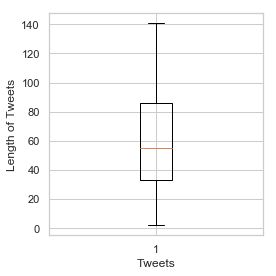

In [7]:
# Create a boxplot of tweet length
plt.figure(figsize=(8, 4))
sns.set(font_scale=1)
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(4, 4))
plt.boxplot(twitter_dataset.clean_len)
plt.xlabel('Tweets')
plt.ylabel('Length of Tweets')
plt.tight_layout()
plt.show()



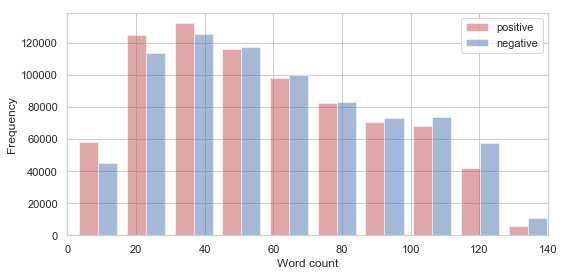

In [9]:
plt.figure(figsize=(8, 4))
sns.set(font_scale=1)
sns.set_style('whitegrid')
positive = twitter_dataset['clean_len'][twitter_dataset.target == 1]
negative = twitter_dataset['clean_len'][twitter_dataset.target == 0]
plt.xlim(0,140)
plt.xlabel('Word count')
plt.ylabel('Frequency')
g = plt.hist([positive, negative], color=['r','b'], alpha=0.5, label=['positive','negative'])
plt.legend(loc=0)
plt.tight_layout()
plt.show()



In [13]:
print('Number of positive tweets: {}'.format(len(twitter_dataset['target'][twitter_dataset.target == 1])))
print('Number of negative tweets: {}'.format(len(twitter_dataset['target'][twitter_dataset.target == 0])))
print('Total number of tweets:    {}'.format(twitter_dataset.shape[0]))



Number of positive tweets: 797844
Number of negative tweets: 798197
Total number of tweets:    1596041


### Training, validation, and test split

In [5]:
y = twitter_dataset['target']
X = twitter_dataset['text']

print('Shape of data:', X.shape)
print('Shape of label:', y.shape)


Shape of data: (1596041,)
Shape of label: (1596041,)


In [6]:
from sklearn.model_selection import train_test_split


# Train, Validation, and Test set : 98%, 2%, 2% 

X_train, X, y_train, y = train_test_split(X, y, test_size = 0.02, random_state = 101)
X_val, X_test, y_val, y_test = train_test_split(X, y, test_size = 0.5, random_state = 101)



In [5]:
print ('Train set has {0} tweets with {1:.2f}% positive and {2:.2f}% negative sentiments'.format(len(X_train),
    (len(X_train[y_train == 1]) / (len(X_train)*1.))*100, 
    (len(X_train[y_train == 0]) / (len(X_train)*1.))*100))

print('Validation set has {0} tweets with {1:.2f}% positive and {2:.2f}% negative sentiments'.format(len(X_val), 
    (len(X_val[y_val == 1]) / (len(X_val)*1.))*100,
    (len(X_val[y_val == 0]) / (len(X_val)*1.))*100 ))

print('Test set has {0} tweets with {1:.2f}% positive and {2:.2f}% negative sentiments'.format(len(X_test), 
    (len(X_test[y_test == 1]) / (len(X_test)*1.))*100,
    (len(X_test[y_test == 0]) / (len(X_test)*1.))*100 ))



Train set has 1564120 tweets with 49.98% positive and 50.02% negative sentiments
Validation set has 15960 tweets with 50.27% positive and 49.73% negative sentiments
Test set has 15961 tweets with 50.68% positive and 49.32% negative sentiments


### Tokenization

In [7]:

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Number of words to consider as features
max_features = 100000
# Cuts off the text after this number of words
maxlen = 60
# Create a tokenizer, configured to only take into account the 100,000 most common words
tokenizer = Tokenizer(num_words = max_features)
# Build the word index
tokenizer.fit_on_texts(twitter_dataset['text'].values)
# Turn strings into lists of integer indices
train_sequences = tokenizer.texts_to_sequences(X_train)
# All sequences in abatch must have the same length
# Sequences with length less than maxlen should be padded with zeros
# Sequences with length longer than maxlen should be truncated
X_train_sequences = pad_sequences(train_sequences, maxlen=maxlen)



In [9]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))


Found 264939 unique tokens.


In [10]:
print('Shape of X_train_sequences:', X_train_sequences.shape)



Shape of X_train_sequences: (1564120, 60)


In [8]:

# Validation set
val_sequences = tokenizer.texts_to_sequences(X_val)
X_val_sequences = pad_sequences(val_sequences, maxlen=maxlen)



In [12]:
print('Shape of X_val_sequences:', X_val_sequences.shape)



Shape of X_val_sequences: (15960, 60)


### Word2Vec implementation



In [9]:
from tqdm import tqdm
# tqdm.pandas(desc="progress-bar")
import gensim
from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import TaggedDocument
import multiprocessing
from sklearn import utils

cores = multiprocessing.cpu_count()



/anaconda3/lib/python3.7/site-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


In [11]:
def labelize_tweets_ug(tweets,label):
    result = []
    prefix = label
    for i, t in zip(tweets.index, tweets):
        result.append(TaggedDocument(t.split(), [prefix + '_%s' % i]))
    return result



In [12]:
# Combine X_train, X_val, X_test
all_x = pd.concat([X_train, X_val, X_test])
all_x_w2v = labelize_tweets_ug(all_x, 'all')



In [33]:

from gensim.models import word2vec


# CBOW

model_ug_cbow = Word2Vec( workers = cores, # Number of parallel threads
                          size = 100, # Word vector dimensionality
                          min_count= 2, # Minimum word count
                          window= 5, # Context window size
                          alpha = 0.07, # The initial learning rate
                          min_alpha = 0.07) # Learning rate will linearly drop to `min_alpha` as training progresses
                  
model_ug_cbow.build_vocab([x.words for x in tqdm(all_x_w2v)])



100%|██████████| 1596041/1596041 [00:00<00:00, 2450877.83it/s]


In [34]:
# train model_ug_cbow
for epoch in range(20):
    model_ug_cbow.train(utils.shuffle([x.words for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_cbow.alpha -= 0.001
    model_ug_cbow.min_alpha = model_ug_cbow.alpha


100%|██████████| 1596041/1596041 [00:00<00:00, 2144991.75it/s]


In [35]:
# skip-gram

model_ug_sg = Word2Vec( workers = cores, # Number of parallel threads
                          size = 100, # Word vector dimensionality
                          min_count= 2, # Minimum word count
                          window= 5, # Context window size
                          alpha = 0.07, # The initial learning rate
                          min_alpha = 0.07, # Learning rate will linearly drop to `min_alpha` as training progresses
                          sg = 1) # skip-gram
model_ug_sg.build_vocab([x.words for x in tqdm(all_x_w2v)])



100%|██████████| 1596041/1596041 [00:00<00:00, 2233417.77it/s]


In [36]:
# # train model_ug_sg
for epoch in range(20):
    model_ug_sg.train(utils.shuffle([x.words for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_sg.alpha -= 0.001
    model_ug_sg.min_alpha = model_ug_sg.alpha
    

100%|██████████| 1596041/1596041 [00:00<00:00, 2101743.19it/s]


In [37]:
# Save models
model_ug_cbow.save('w2v_model_ug_cbow.word2vec')
model_ug_sg.save('w2v_model_ug_sg.word2vec')



In [15]:
from gensim.models import KeyedVectors
model_ug_cbow = KeyedVectors.load('w2v_model_ug_cbow.word2vec')
model_ug_sg = KeyedVectors.load('w2v_model_ug_sg.word2vec')



/anaconda3/lib/python3.7/site-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


In [39]:
len(model_ug_cbow.wv.vocab.keys())



106259

In [40]:
# summarize the loaded model
print(model_ug_cbow)


Word2Vec(vocab=106259, size=100, alpha=0.04999999999999999)


In [41]:
# This will print the most similar words present in the model
model_ug_cbow.wv.most_similar("awful")


[('horrid', 0.7177104949951172),
 ('terrible', 0.7017079591751099),
 ('horrible', 0.6580729484558105),
 ('unfortunate', 0.5949237942695618),
 ('horrific', 0.5796113610267639),
 ('crappy', 0.5668225288391113),
 ('awfull', 0.5627615451812744),
 ('rubbish', 0.560499906539917),
 ('incredible', 0.554601788520813),
 ('disgusting', 0.5360323190689087)]

In [42]:
# compute similarity between two words
model_ug_cbow.wv.similarity(w1 = "awful", w2 = "terrible")


0.7017079564125605

In [43]:
# This will print the odd word among them 
model_ug_cbow.wv.doesnt_match("man woman girl boy kitchen".split())


'kitchen'

In [44]:
# This will give the total number of words in the vocabolary created from this dataset
model_ug_cbow.wv.syn0.shape


/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  


(106259, 100)

In [45]:
len(model_ug_sg.wv.vocab.keys())


106259

In [22]:
model_ug_sg.wv.similarity(w1 = "great", w2 = "awful")

0.28302139629319223

In [46]:
# summarize the loaded model
print(model_ug_sg)


Word2Vec(vocab=106259, size=100, alpha=0.04999999999999999)


In [23]:
# Visualize Word Embedding
# retrieve all of the vectors from the trained model
X_vec_cbow = model_ug_cbow[model_ug_cbow.wv.vocab]



/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [24]:
# create a 2-dimensional PCA model of the word vectors
from sklearn.decomposition import PCA
pca_cbow = PCA(n_components=2)
result_cbow = pca_cbow.fit_transform(X_vec_cbow[:20])



In [32]:
model_ug_cbow.wv.most_similar("awful")

[('horrible', 0.6861467957496643),
 ('aweful', 0.6575475335121155),
 ('terrible', 0.6431080102920532),
 ('horrid', 0.6016123294830322),
 ('odd', 0.5759574174880981),
 ('unfortunate', 0.5712158679962158),
 ('unpleasant', 0.5689526796340942),
 ('unreal', 0.5518292188644409),
 ('disgusting', 0.5493462085723877),
 ('intense', 0.5428169965744019)]

In [31]:
model_ug_cbow.wv.most_similar("great")

[('fantastic', 0.6799850463867188),
 ('wonderful', 0.6780930757522583),
 ('fabulous', 0.6727688312530518),
 ('fab', 0.6368978023529053),
 ('nice', 0.5952551364898682),
 ('fantabulous', 0.5830315351486206),
 ('superb', 0.5693763494491577),
 ('amazing', 0.5689162611961365),
 ('good', 0.5605049729347229),
 ('agreat', 0.5584819316864014)]

In [30]:
list(model_ug_cbow.wv.vocab)[:10]

['did', 'until', 'last', 'week', 'will', 'put', 'my', 'late', 'great', 'kitty']

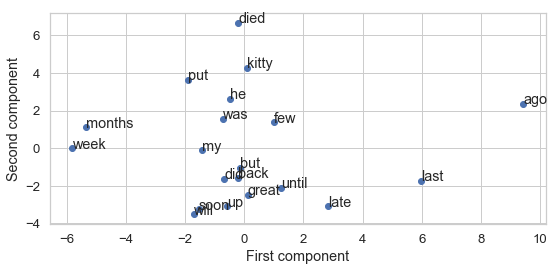

In [36]:
plt.figure(figsize=(8, 4))
sns.set(font_scale=1.2)
sns.set_style('whitegrid')
# Plot the resulting projection
plt.scatter(result_cbow[:, 0], result_cbow[:, 1])

# annotate the points on the graph with the words themselves
words_cbow = list(model_ug_cbow.wv.vocab)
#words_list = ['awful','horrible','terrible','horrid','odd','unfortunate','unpleasant',
#              'unreal','disgusting',"great",'fantastic','wonderful','fabulous','fab',
#               'nice','fantabulous','superb','amazing','good']
for i, word in enumerate(words_cbow[:20]):
    plt.annotate(word, xy=(result_cbow[i, 0], result_cbow[i, 1]))
plt.xlabel('First component')
plt.ylabel('Second component')
plt.tight_layout()
plt.show()


In [11]:
# Create a dictionary to extract word vectors from
# concatenate vectors of the two models
# Then each word will have 400 dimension
embeddings_index = {}
for w in model_ug_cbow.wv.vocab.keys():
    embeddings_index[w] = np.append(model_ug_cbow.wv[w], model_ug_sg.wv[w])
print('Found %s word vectors.' % len(embeddings_index))



Found 106259 word vectors.


In [12]:
# create a matrix of word vectors
embedding_matrix = np.zeros((max_features, 200))
for word, i in tokenizer.word_index.items():
    if i >= max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
        
        

### Modeling



In [11]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

# EarlyStopping: 
# Interrupts training when improvement stops
# Monitors the model’s validation accuracy
# Interrupts training when accuracy has stopped improving 
# for more than two epoch (that is, three epochs)
# EarlyStopping(monitor='acc', patience=2)

# ModelCheckpoint:
# Saves the current weights after every epoch
# you won’t overwrite the model file unless val_loss has improved, 
# which allows you to keep the best model seen during training.

# ReduceLROnPlateau:
# Reduce learning rate when the validation loss stopped improving
# Divides the learning rate by 10 when triggered
# The callback is triggered after the validation loss has stopped improving for 3 epochs.

# TensorBoard: 
# Visually monitor metrics, histograms of activations and gradients during training
# Records activation histograms every 1 epoch
# Records embedding data every 1 epoch
# TensorBoard(histogram_freq=1, embeddings_freq=1)

def callbacks_list (model_suffix):
    
    
    callbacks_list = [ModelCheckpoint(filepath='model_%s.h5'% model_suffix, 
                                      monitor='val_loss', 
                                      save_best_only=True), 
                      ReduceLROnPlateau(monitor='val_loss', 
                                       factor = 0.1,
                                       patience = 3)]
                      
    
    return callbacks_list



In [12]:
from keras.optimizers import adam
# compile the model
def compile_model (model, optimizer=adam(lr=0.001), 
                   loss='binary_crossentropy', metrics=['acc']):
    
    return model.compile(optimizer=optimizer, 
                         loss=loss, 
                         metrics=metrics)
    

Instructions for updating:
Colocations handled automatically by placer.


In [13]:
# fit on the training set
def fit_model (model , callbacks, X_train = X_train_sequences, y_train = y_train,
               epochs=6, batch_size=256, 
               validation_data = (X_val_sequences, y_val)):
    
    history = model.fit(X_train, y_train, 
                        epochs=epochs, 
                        batch_size=batch_size,  
                        validation_data=validation_data,
                        callbacks=callbacks)
                        
    
    return history


In [14]:
def performance_plot (history, model_name):
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    
    plt.figure(figsize=(10,5))
    sns.set(font_scale=1.2)   
    sns.set_style('darkgrid')

    plt.subplot(1,2,1)   
    plt.plot(epochs, acc, '-', label='Training acc')
    plt.plot(epochs, val_acc, '--', label='Validation acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and validation accuracy')
    plt.legend(loc=0)


    plt.subplot(1,2,2)
    plt.plot(epochs, loss, '-', label='Training loss')
    plt.plot(epochs, val_loss, '--', label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and validation loss')
    plt.legend(loc=0)
    
    plt.tight_layout()
    plt.savefig('%s.png'% model_name)
    plt.show()
    
    

In [21]:
#import tensorflow as tf
# This prevents that resource exhausted error assuming you're batch size is within reason.
#config = tf.ConfigProto()
#config.gpu_options.allow_growth = True
#Now when creating your session pass this config to it.
#sess = tf.Session(config=config)

I want to try three different approaches for the embedding layer to understand which one achieves the highest accuracy for the validation set. In the first approach, I use the pre-trained word2vec representation I already created with the help of gensim library in the embedding layer when freeaing the weights for this layer to not update the weights. For the second approach, I will use keras embedding layer to build a numerical representation of tweets from scratch. Finally, in the third approach, I will use the pre-trained word2vec representation again but this time allow the network to update the weights. I will implement the three mentioned approaches in a feed-forward neural net and after picking the best approach I will just use it for the LSTM and CNN architectures.



### Feed-Forward ( fixed pre-trained word2vec)

In [13]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten, Dropout
from keras.models import load_model

# embed_dim : Embedding dimensionality


# Model 1: 
# A simple Neural Net (Embedding + Flatten + Dropout + Dense)
# Use pre-trained word embedding. Set the weights attribute equal to our embedding_matrix.
# we do not want to update the learned word weights in this model, 
# therefore we will set the trainable attribute for the model to be False.

def model_1 (max_features = 100000, embed_dim = 200 , dropout = 0.5, 
             embedding_matrix = embedding_matrix, output_dense_dim = 256):

    model = Sequential()
    model.add(Embedding(max_features, embed_dim, weights=[embedding_matrix], 
                          input_length = maxlen, trainable=False))
    # Flattens the 3D tensor of embeddings into a 
    # 2D tensor of shape (samples, maxlen * embed_dim)
    model.add(Flatten())
    # First dense layer
    model.add(Dense(output_dense_dim, activation='relu'))
    # dropout
    model.add(Dropout(dropout))
    # Adds the classifier on top
    model.add(Dense(1, activation='sigmoid'))
    
    print(model.summary())
    
    return model



In [56]:
# Using pre-trained word2vec
model_1_w2v = model_1(embedding_matrix = embedding_matrix, output_dense_dim = 256)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 60, 200)           20000000  
_________________________________________________________________
flatten_2 (Flatten)          (None, 12000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               3072256   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 23,072,513
Trainable params: 3,072,513
Non-trainable params: 20,000,000
_________________________________________________________________


In [57]:

# compile the model
compile_model(model_1_w2v)

# fit on the training set
history_1_w2v = fit_model(model_1_w2v, callbacks_list('1_w2v'), batch_size=256)


Train on 1564120 samples, validate on 15960 samples
Epoch 1/6
1564120/1564120 [==============================] - 1132s 724us/step - loss: 0.4770 - acc: 0.7702 - val_loss: 0.4444 - val_acc: 0.7919
Epoch 2/6
1564120/1564120 [==============================] - 884s 565us/step - loss: 0.4493 - acc: 0.7887 - val_loss: 0.4371 - val_acc: 0.7958
Epoch 3/6
1564120/1564120 [==============================] - 862s 551us/step - loss: 0.4326 - acc: 0.7991 - val_loss: 0.4330 - val_acc: 0.8002
Epoch 4/6
1564120/1564120 [==============================] - 845s 540us/step - loss: 0.4189 - acc: 0.8068 - val_loss: 0.4308 - val_acc: 0.7999
Epoch 5/6
1564120/1564120 [==============================] - 876s 560us/step - loss: 0.4070 - acc: 0.8140 - val_loss: 0.4323 - val_acc: 0.7998
Epoch 6/6
1564120/1564120 [==============================] - 970s 620us/step - loss: 0.3959 - acc: 0.8203 - val_loss: 0.4344 - val_acc: 0.7974


In [65]:
# Load the best model
from keras.models import load_model
best_model_1_w2v = load_model('model_1_w2v.h5')
Loss, Accuracy = best_model_1_w2v.evaluate(x=X_val_sequences, y=y_val)
print('Feed-Forward (fixed pre-trained word2vec)')
print('Accuracy: %f' % (Accuracy*100))


15960/15960 [==============================] - 2s 137us/step
Feed-Forward ( fixed pre-trained word2vec)
Accuracy: 79.993734


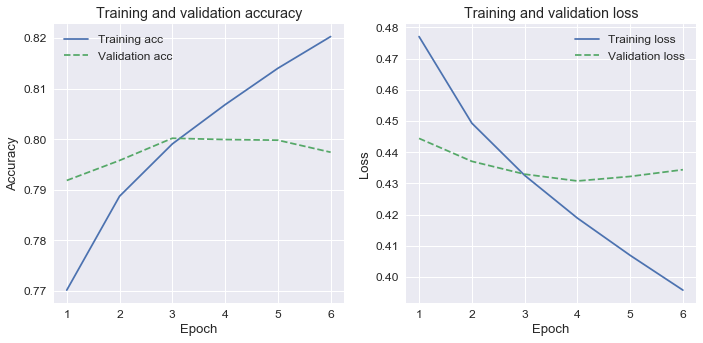

In [108]:
performance_plot (history_1_w2v)



### Feed-Forward ( learn an Embedding from scratch)

In [16]:


# Model 2: 
# A simple Neural Net (Embedding + Flatten + Dropout + Dense)
# Learn Embedding from scratch


def model_2 (max_features = 100000, embed_dim = 200 , dropout = 0.5, output_dense_dim = 256):

    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length = maxlen))
    # Flattens the 3D tensor of embeddings into a 
    # 2D tensor of shape (samples, maxlen * embed_dim)
    model.add(Flatten())
    # First dense layer
    model.add(Dense(output_dense_dim, activation='relu'))
    # dropout
    model.add(Dropout(dropout))
    # Adds the classifier on top
    model.add(Dense(1, activation='sigmoid'))
    
    print(model.summary())
    
    return model




In [67]:
# Learn Embedding from scratch
model_2_le = model_2(output_dense_dim = 256)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 60, 200)           20000000  
_________________________________________________________________
flatten_3 (Flatten)          (None, 12000)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               3072256   
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 23,072,513
Trainable params: 23,072,513
Non-trainable params: 0
_________________________________________________________________


In [68]:
# compile the model
compile_model(model_2_le)

# fit on the training set
history_2_le = fit_model(model_2_le, callbacks_list('2_le'), batch_size=256)



Train on 1564120 samples, validate on 15960 samples
Epoch 1/6
1564120/1564120 [==============================] - 4693s 3ms/step - loss: 0.4342 - acc: 0.8010 - val_loss: 0.4021 - val_acc: 0.8185
Epoch 2/6
1564120/1564120 [==============================] - 4528s 3ms/step - loss: 0.3777 - acc: 0.8312 - val_loss: 0.4051 - val_acc: 0.8157
Epoch 3/6
1564120/1564120 [==============================] - 4824s 3ms/step - loss: 0.3272 - acc: 0.8559 - val_loss: 0.4313 - val_acc: 0.8130
Epoch 4/6
1564120/1564120 [==============================] - 4427s 3ms/step - loss: 0.2796 - acc: 0.8780 - val_loss: 0.4970 - val_acc: 0.8064
Epoch 5/6
1564120/1564120 [==============================] - 3862s 2ms/step - loss: 0.2434 - acc: 0.8948 - val_loss: 0.5348 - val_acc: 0.8011
Epoch 6/6
1564120/1564120 [==============================] - 3813s 2ms/step - loss: 0.1891 - acc: 0.9193 - val_loss: 0.6735 - val_acc: 0.7987


In [69]:
# Load the best model
best_model_2_le = load_model('model_2_le.h5')
Loss, Accuracy = best_model_2_le.evaluate(x=X_val_sequences, y=y_val)
print('Feed-Forward (learn an embedding from scratch)')
print('Accuracy: %f' % (Accuracy*100))



15960/15960 [==============================] - 2s 144us/step
Feed-Forward (learn an embedding from scratch)
Accuracy: 81.848371


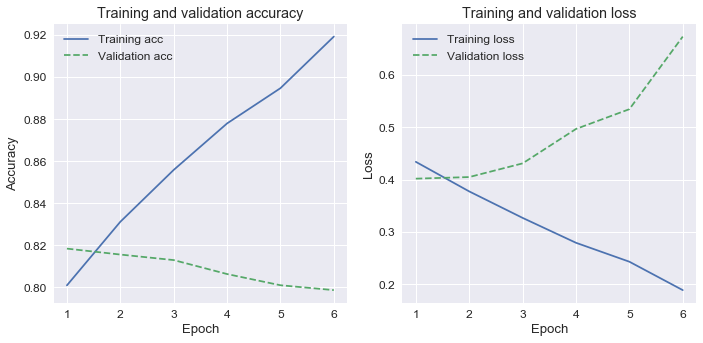

In [106]:
performance_plot (history_2_le)


The result shows overfitting after the first epoch. So, I decided to add L2 regularization to embedding layer and compile the model again.

### Feed-Forward ( learn an Embedding from scratch with L2 regularization)

In [14]:
# Model 2_l2: 
# A simple Neural Net (Embedding + Flatten + Dropout + Dense)
# Learn Embedding from scratch
# Use L2 regulizer in Embedding layer
from keras import regularizers

def model_2_l2 (max_features = 100000, embed_dim = 200 , dropout = 0.5, 
             output_dense_dim = 256, embeddings_regularizer = regularizers.l2(1e-6)):

    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length = maxlen, 
                        embeddings_regularizer = embeddings_regularizer))
    # Flattens the 3D tensor of embeddings into a 
    # 2D tensor of shape (samples, maxlen * embed_dim)
    model.add(Flatten())
    # First dense layer
    model.add(Dense(output_dense_dim, activation='relu'))
    # dropout
    model.add(Dropout(dropout))
    # Adds the classifier on top
    model.add(Dense(1, activation='sigmoid'))
    
    print(model.summary())
    
    return model




In [72]:
# Learn Embedding from scratch
model_2_l2_le = model_2_l2(output_dense_dim = 256)




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 60, 200)           20000000  
_________________________________________________________________
flatten_4 (Flatten)          (None, 12000)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               3072256   
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 257       
Total params: 23,072,513
Trainable params: 23,072,513
Non-trainable params: 0
_________________________________________________________________


In [73]:
# compile the model
compile_model(model_2_l2_le)

# fit on the training set
history_2_l2_le = fit_model(model_2_l2_le, callbacks_list('2_l2_le'), batch_size=256)



Train on 1564120 samples, validate on 15960 samples
Epoch 1/6
1564120/1564120 [==============================] - 5167s 3ms/step - loss: 0.4518 - acc: 0.7947 - val_loss: 0.4215 - val_acc: 0.8107
Epoch 2/6
1564120/1564120 [==============================] - 5119s 3ms/step - loss: 0.4123 - acc: 0.8164 - val_loss: 0.4164 - val_acc: 0.8110
Epoch 3/6
1564120/1564120 [==============================] - 5094s 3ms/step - loss: 0.3937 - acc: 0.8261 - val_loss: 0.4152 - val_acc: 0.8130
Epoch 4/6
1564120/1564120 [==============================] - 5249s 3ms/step - loss: 0.3733 - acc: 0.8373 - val_loss: 0.4182 - val_acc: 0.8152
Epoch 5/6
1564120/1564120 [==============================] - 6224s 4ms/step - loss: 0.3485 - acc: 0.8510 - val_loss: 0.4306 - val_acc: 0.8108
Epoch 6/6
1564120/1564120 [==============================] - 6148s 4ms/step - loss: 0.3214 - acc: 0.8654 - val_loss: 0.4485 - val_acc: 0.8057


In [74]:
# Load the best model
best_model_2_l2_le = load_model('model_2_l2_le.h5')
Loss, Accuracy = best_model_2_l2_le.evaluate(x=X_val_sequences, y=y_val)
print('Feed-Forward (learn an embedding from scratch with L2 regularization)')
print('Accuracy: %f' % (Accuracy*100))



15960/15960 [==============================] - 38s 2ms/step
Feed-Forward (learn an embedding from scratch with L2 regularization)
Accuracy: 81.303258


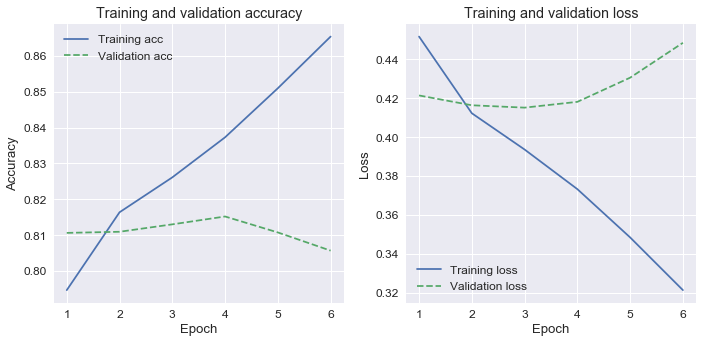

In [104]:
performance_plot (history_2_l2_le)



It seems adding L2 regularization helped in decreasing overfitting. So, I will use L2 regularization for the next architecture as well.




### Feed-Forward ( fine-tuning pre-trained word2vec with L2 regularization)



In [21]:

# Model 3: 
# A simple Neural Net (Embedding + Flatten + Dropout + Dense)
# Learning Embedding from word2vec (fine-tune pre-trained word2vec)
# we want to update the learned word weights in this model, 
# therefore we will set the trainable attribute for the model to be True.
# Here, embedding_matrix works as an initialization for embedding layer
# Use L2 regularization in Embedding layer




def model_3_l2 (max_features = 100000, embed_dim = 200 , dropout = 0.5, 
             embedding_matrix = embedding_matrix, output_dense_dim = 256, 
             embeddings_regularizer = regularizers.l2(1e-6)):

    model = Sequential()
    model.add(Embedding(max_features, embed_dim, weights=[embedding_matrix], 
                        input_length = maxlen, trainable=True, 
                        embeddings_regularizer = embeddings_regularizer))
    # Flattens the 3D tensor of embeddings into a 
    # 2D tensor of shape (samples, maxlen * embed_dim)
    model.add(Flatten())
    # First dense layer
    model.add(Dense(output_dense_dim, activation='relu'))
    # dropout
    model.add(Dropout(dropout))
    # Adds the classifier on top
    model.add(Dense(1, activation='sigmoid'))
    
    print(model.summary())
    
    return model



In [103]:
# fine-tune pre-trained word2vec
model_3_l2_lew2v = model_3_l2(output_dense_dim = 256)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 60, 200)           20000000  
_________________________________________________________________
flatten_6 (Flatten)          (None, 12000)             0         
_________________________________________________________________
dense_21 (Dense)             (None, 256)               3072256   
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 257       
Total params: 23,072,513
Trainable params: 23,072,513
Non-trainable params: 0
_________________________________________________________________
None


In [78]:
# compile the model
compile_model(model_3_l2_lew2v)

# fit on the training set
history_3_l2_lew2v = fit_model(model_3_l2_lew2v, callbacks_list('3_l2_lew2v'), batch_size=256)


Train on 1564120 samples, validate on 15960 samples
Epoch 1/6
1564120/1564120 [==============================] - 6198s 4ms/step - loss: 4.9531 - acc: 0.7889 - val_loss: 3.3406 - val_acc: 0.8078
Epoch 2/6
1564120/1564120 [==============================] - 6562s 4ms/step - loss: 2.5439 - acc: 0.8133 - val_loss: 1.9537 - val_acc: 0.8167
Epoch 3/6
1564120/1564120 [==============================] - 6316s 4ms/step - loss: 1.6047 - acc: 0.8230 - val_loss: 1.3519 - val_acc: 0.8189
Epoch 4/6
1564120/1564120 [==============================] - 6377s 4ms/step - loss: 1.1665 - acc: 0.8308 - val_loss: 1.0549 - val_acc: 0.8198
Epoch 5/6
1564120/1564120 [==============================] - 6777s 4ms/step - loss: 0.9345 - acc: 0.8372 - val_loss: 0.8942 - val_acc: 0.8174
Epoch 6/6
1564120/1564120 [==============================] - 5922s 4ms/step - loss: 0.7966 - acc: 0.8434 - val_loss: 0.7973 - val_acc: 0.8175


In [79]:
# Load the best model
best_model_3_l2_lew2v = load_model('model_3_l2_lew2v.h5')
Loss, Accuracy = best_model_3_l2_lew2v.evaluate(x=X_val_sequences, y=y_val)
print('Feed-Forward (fine-tune pre-trained word2vec with L2 regularization)')
print('Accuracy: %f' % (Accuracy*100))



15960/15960 [==============================] - 36s 2ms/step
Feed-Forward (fine-tune pre-trained word2vec with L2 regularization)
Accuracy: 81.748120


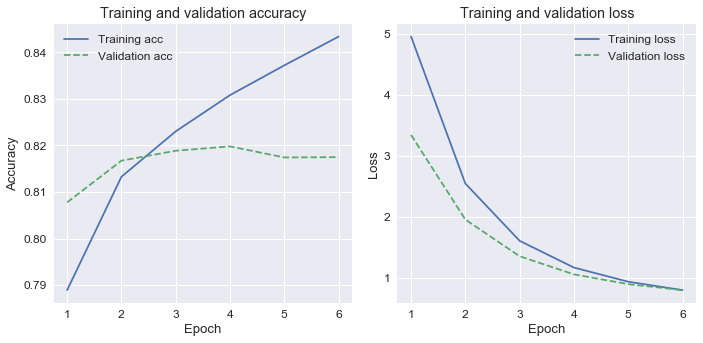

In [101]:
performance_plot (history_3_l2_lew2v)


After building three feed-forward neural nets with three different approach for the embedding layer and comparing the validation accuracy for the best model in each approach, we reached to the following conclusion: 



While the validation accuracy of these three variations are pretty close but the model with fixed pre-trained embedding layer (pre-trained word2vec) achieved the lowest accuracy among all three models. The model with pre-trained embedding layer (pre-trained word2vec) when fine-tuning the embedding layer (set trainable = True) outperformed the other two approaches. 



### LSTM (fine-tune pre-trained word2vec)



In [15]:
from keras.layers import LSTM

# Model 4: 
# A simple LSTM (Embedding + LSTM + Dense)
# Unfrozen embedding layer (fine-tune pre-trained word2vec)

# LSTM_out : The LSTM output dimensionality
# embed_dim: Embedding dimensionality

def model_4 (max_features = 100000, embed_dim = 200, dropout = 0.2, recurrent_dropout = 0.2, 
             LSTM_out = 128, output_dense_dim = 256, embedding_matrix = embedding_matrix, 
             embeddings_regularizer = regularizers.l2(1e-6)):

    model = Sequential()
    
    model.add(Embedding(max_features, embed_dim, weights =[embedding_matrix],
                        input_length = maxlen, trainable = True, 
                        embeddings_regularizer = embeddings_regularizer))
    
    model.add(LSTM(LSTM_out, dropout = dropout, recurrent_dropout = recurrent_dropout))
    
    model.add(Dense(output_dense_dim, activation='relu'))
    
    model.add(Dropout(dropout))
    
    model.add(Dense(1, activation='sigmoid'))
    
    print(model.summary())
    
    return model




In [100]:
# LSTM (fine-tune pre-trained word2vec)
model_4_w2v = model_4(dropout = 0.2, recurrent_dropout = 0.2, output_dense_dim = 256)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 60, 200)           20000000  
_________________________________________________________________
lstm_7 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dense_19 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 257       
Total params: 20,201,729
Trainable params: 20,201,729
Non-trainable params: 0
_________________________________________________________________
None


In [85]:

# compile the model
compile_model(model_4_w2v)

# fit on the training set
history_4_w2v = fit_model(model_4_w2v, callbacks_list('4_w2v'), batch_size=256)


Train on 1564120 samples, validate on 15960 samples
Epoch 1/6
1564120/1564120 [==============================] - 10036s 6ms/step - loss: 4.8059 - acc: 0.7950 - val_loss: 3.1214 - val_acc: 0.8181
Epoch 2/6
1564120/1564120 [==============================] - 9118s 6ms/step - loss: 2.3246 - acc: 0.8158 - val_loss: 1.7208 - val_acc: 0.8262
Epoch 3/6
1564120/1564120 [==============================] - 9075s 6ms/step - loss: 1.3995 - acc: 0.8243 - val_loss: 1.1405 - val_acc: 0.8291
Epoch 4/6
1564120/1564120 [==============================] - 9177s 6ms/step - loss: 0.9909 - acc: 0.8294 - val_loss: 0.8654 - val_acc: 0.8334
Epoch 5/6
1564120/1564120 [==============================] - 10034s 6ms/step - loss: 0.7871 - acc: 0.8331 - val_loss: 0.7217 - val_acc: 0.8343
Epoch 6/6
1564120/1564120 [==============================] - 10032s 6ms/step - loss: 0.6737 - acc: 0.8364 - val_loss: 0.6371 - val_acc: 0.8357


In [86]:
# Load the best model
best_model_4_w2v = load_model('model_4_w2v.h5')
Loss, Accuracy = best_model_4_w2v.evaluate(x=X_val_sequences, y=y_val)
print('LSTM (fine-tune pre-trained word2vec with L2 regularization)')
print('Accuracy: %f' % (Accuracy*100))



15960/15960 [==============================] - 57s 4ms/step
LSTM (fine-tune pre-trained word2vec with L2 regularization)
Accuracy: 83.571429


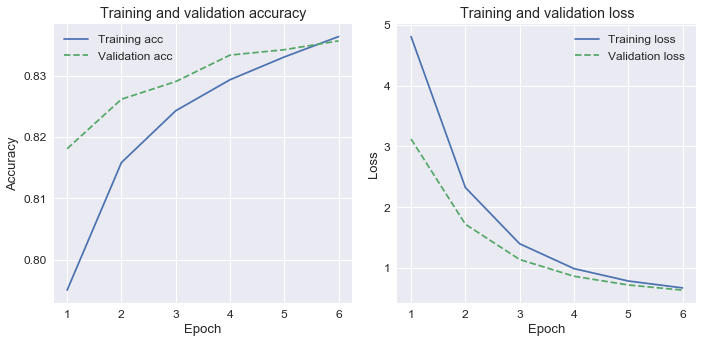

In [97]:
performance_plot (history_4_w2v)



In [ ]:
### LSTM (Fixed pre-trained word2vec)

In [23]:
from keras.layers import LSTM

# Model 4: 
# A simple LSTM (Embedding + LSTM + Dense)
# Unfrozen embedding layer (fine-tune pre-trained word2vec)

# LSTM_out : The LSTM output dimensionality
# embed_dim: Embedding dimensionality

def model_4_f (max_features = 100000, embed_dim = 200, dropout = 0.2, recurrent_dropout = 0.2, 
             LSTM_out = 128, output_dense_dim = 256, embedding_matrix = embedding_matrix): 
             

    model = Sequential()
    
    model.add(Embedding(max_features, embed_dim, weights =[embedding_matrix],
                        input_length = maxlen, trainable = False))
                        
    
    model.add(LSTM(LSTM_out, dropout = dropout, recurrent_dropout = recurrent_dropout))
    
    model.add(Dense(output_dense_dim, activation='relu'))
    
    model.add(Dropout(dropout))
    
    model.add(Dense(1, activation='sigmoid'))
    
    print(model.summary())
    
    return model




In [ ]:
# LSTM (fine-tune pre-trained word2vec)
model_4_w2v_fixed = model_4_f(dropout = 0.2, recurrent_dropout = 0.2, output_dense_dim = 256)



In [ ]:
# compile the model
compile_model(model_4_w2v_fixed)

# fit on the training set
history_4_w2v_fixed = fit_model(model_4_w2v_fixed, callbacks_list('4_w2v_fixed'), batch_size=256)



In [ ]:
# Load the best model
best_model_4_w2v_fixed = load_model('model_4_w2v_fixed.h5')
Loss, Accuracy = best_model_4_w2v_fixed.evaluate(x=X_val_sequences, y=y_val)
print('LSTM (Fixed pre-trained word2vec)')
print('Accuracy: %f' % (Accuracy*100))



In [ ]:
performance_plot (history_4_w2v_fixed)



### Stacked LSTM



In [24]:

# Model 5: 
# Stacked LSTM
# To stack recurrent layers on top of each other, we need to specify return_sequences=True
# for all intermediate layers to return their full sequence of outputs
# rather than their output at the last timestep.


def model_5 (max_features = 100000, embed_dim = 200, dropout = 0.2, recurrent_dropout = 0.2, 
             output_dense_dim = 256, embedding_matrix = embedding_matrix, 
             LSTM_out_1 = 128, LSTM_out_2 = 128, LSTM_out_3 = 128, 
             embeddings_regularizer = regularizers.l2(1e-6)):
    
    model = Sequential()

    model.add(Embedding(max_features, embed_dim, weights =[embedding_matrix],
                        input_length = maxlen, trainable = True, 
                        embeddings_regularizer = embeddings_regularizer))

    model.add(LSTM(LSTM_out_1, 
                   dropout=dropout, 
                   recurrent_dropout=recurrent_dropout, 
                   return_sequences=True))

    model.add(LSTM(LSTM_out_2, 
                   dropout=dropout, 
                   recurrent_dropout=recurrent_dropout, 
                   return_sequences=True))

    model.add(LSTM(LSTM_out_3, 
                   dropout=dropout, 
                   recurrent_dropout=recurrent_dropout))
    
    model.add(Dense(output_dense_dim, activation='relu'))
    
    model.add(Dropout(dropout))

    model.add(Dense(1, activation='sigmoid'))
    
    print(model.summary())
    
    return model



In [92]:

# Stacked LSTM (fine-tune pre-trained word2vec)
model_5_w2v = model_5(dropout = 0.2, recurrent_dropout = 0.2, output_dense_dim = 256)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 60, 200)           20000000  
_________________________________________________________________
lstm_3 (LSTM)                (None, 60, 128)           168448    
_________________________________________________________________
lstm_4 (LSTM)                (None, 60, 128)           131584    
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_15 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 257       
Total para

In [93]:

# compile the model
compile_model(model_5_w2v)

# fit on the training set
history_5_w2v = fit_model(model_5_w2v, callbacks_list('5_w2v'), batch_size=256)



Train on 1564120 samples, validate on 15960 samples
Epoch 1/6
1564120/1564120 [==============================] - 19615s 13ms/step - loss: 4.7874 - acc: 0.7924 - val_loss: 3.0916 - val_acc: 0.8204
Epoch 2/6
1564120/1564120 [==============================] - 19204s 12ms/step - loss: 2.2955 - acc: 0.8142 - val_loss: 1.6867 - val_acc: 0.8265
Epoch 3/6
1564120/1564120 [==============================] - 16762s 11ms/step - loss: 1.3687 - acc: 0.8229 - val_loss: 1.1087 - val_acc: 0.8289
Epoch 4/6
1564120/1564120 [==============================] - 18442s 12ms/step - loss: 0.9649 - acc: 0.8281 - val_loss: 0.8396 - val_acc: 0.8325
Epoch 5/6
1564120/1564120 [==============================] - 19072s 12ms/step - loss: 0.7664 - acc: 0.8323 - val_loss: 0.7028 - val_acc: 0.8319
Epoch 6/6
1564120/1564120 [==============================] - 19500s 12ms/step - loss: 0.6581 - acc: 0.8353 - val_loss: 0.6208 - val_acc: 0.8353


In [95]:
# Load the best model
best_model_5_w2v = load_model('model_5_w2v.h5')
Loss, Accuracy = best_model_5_w2v.evaluate(x=X_val_sequences, y=y_val)
print('Stacked LSTM (fine-tune pre-trained word2vec with L2 regularization)')
print('Accuracy: %f' % (Accuracy*100))



15960/15960 [==============================] - 108s 7ms/step
Stacked LSTM (fine-tune pre-trained word2vec with L2 regularization)
Accuracy: 83.527569


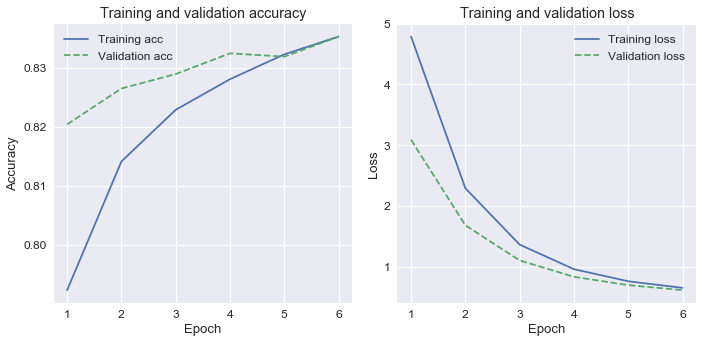

In [96]:
performance_plot (history_5_w2v)



### Bidirectional LSTM



In [16]:
from keras.layers import Bidirectional

# Model 6: 
# Bidirectional LSTM
# Bidirectional creates a second, separate instance for the recurrent layer and it uses
# one instance in chronological order and the other one in the reversed order.

def model_6 (max_features = 100000, embed_dim = 200, dropout = 0.2, recurrent_dropout = 0.2, 
             LSTM_out = 128, output_dense_dim = 256, embedding_matrix = embedding_matrix, 
             embeddings_regularizer = regularizers.l2(1e-6)): 
             

    model = Sequential()

    model.add(Embedding(max_features, embed_dim, weights =[embedding_matrix],
                        input_length = maxlen, trainable = True, 
                        embeddings_regularizer = embeddings_regularizer))

    model.add(Bidirectional(LSTM(LSTM_out, 
                                 dropout=dropout, 
                                 recurrent_dropout=recurrent_dropout,
                                 return_sequences=True))) 
    
    model.add(Flatten())
    
    model.add(Dense(output_dense_dim, activation='relu'))
    
    model.add(Dropout(dropout))

    model.add(Dense(1, activation='sigmoid'))
    
    print(model.summary())
    
    return model




In [17]:
# Bidirectional LSTM (fine-tune pre-trained word2vec)
model_6_w2v = model_6(dropout = 0.2, recurrent_dropout = 0.2, output_dense_dim = 256)




Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 60, 200)           20000000  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 60, 256)           336896    
_________________________________________________________________
flatten_1 (Flatten)          (None, 15360)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               3932416   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)      

In [ ]:
# compile the model
compile_model(model_6_w2v)

# fit on the training set
history_6_w2v = fit_model(model_6_w2v, callbacks_list('6_w2v'), batch_size=256)



In [ ]:
# Load the best model
best_model_6_w2v = load_model('model_6_w2v.h5')
Loss, Accuracy = best_model_6_w2v.evaluate(x=X_val_sequences, y=y_val)
print('Bidirectional LSTM (fine-tune pre-trained word2vec with L2 regularization)')
print('Accuracy: %f' % (Accuracy*100))



In [ ]:
performance_plot (history_6_w2v)


### Stacked Bidirectional LSTM



In [18]:


# Model 7: 
# Bidirectional LSTM
# Bidirectional creates a second, separate instance for the recurrent layer and it uses
# one instance in chronoligical order and the other one in the reversed order.

def model_7 (max_features = 100000, embed_dim = 200, dropout = 0.2, recurrent_dropout = 0.2, 
             output_dense_dim = 256, embedding_matrix = embedding_matrix,
             LSTM_out_1 = 128, LSTM_out_2 = 128,
             embeddings_regularizer = regularizers.l2(1e-6)): 
             

    model = Sequential()

    model.add(Embedding(max_features, embed_dim, weights =[embedding_matrix],
                        input_length = maxlen, trainable = True, 
                        embeddings_regularizer = embeddings_regularizer))

    model.add(Bidirectional(LSTM(LSTM_out_1, 
                                 dropout=dropout, 
                                 recurrent_dropout=recurrent_dropout,
                                return_sequences=True))) 
    
    model.add(Bidirectional(LSTM(LSTM_out_2, 
                                 dropout=dropout, 
                                 recurrent_dropout=recurrent_dropout,
                                return_sequences=True))) 
    
    model.add(Flatten())
    
    model.add(Dense(output_dense_dim, activation='relu'))
    
    model.add(Dropout(dropout))

    model.add(Dense(1, activation='sigmoid'))
    
    print(model.summary())
    
    return model





In [19]:
# Stacked Bidirectional LSTM (fine-tune pre-trained word2vec)
model_7_w2v = model_7(dropout = 0.2, recurrent_dropout = 0.2, output_dense_dim = 256)




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 60, 200)           20000000  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 60, 256)           336896    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 60, 256)           394240    
_________________________________________________________________
flatten_2 (Flatten)          (None, 15360)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               3932416   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total para

In [ ]:
# compile the model
compile_model(model_7_w2v)

# fit on the training set
history_7_w2v = fit_model(model_7_w2v, callbacks_list('7_w2v'), batch_size=256)




In [ ]:
# Load the best model
best_model_7_w2v = load_model('model_7_w2v.h5')
Loss, Accuracy = best_model_7_w2v.evaluate(x=X_val_sequences, y=y_val)
print('Stacked Bidirectional LSTM (fine-tune pre-trained word2vec with L2 regularization)')
print('Accuracy: %f' % (Accuracy*100))



In [ ]:
performance_plot (history_7_w2v)



### CNN (Fixed pre-trained word2vec)


In [24]:
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Flatten

# Model 8: CNN

# nb_filter : Number of filters
# conv_window : Convolution window size


def model_8 (max_features=100000, embed_dim=200, dropout = 0.2, nb_filter = 128, conv_window = 3, 
             pool_size=2, output_dense_dim = 256, embedding_matrix = embedding_matrix): 
             
              

    model = Sequential()

    model.add(Embedding(max_features, embed_dim, weights =[embedding_matrix],
                        input_length = maxlen, trainable = False))
                       

    #model.add(Conv1D(nb_filter, conv_window, activation='relu'))
    
    #model.add(MaxPooling1D(pool_size))
    
    #model.add(Dropout(dropout))
    
    model.add(Conv1D(nb_filter, conv_window, activation='relu'))
    
    model.add(GlobalMaxPooling1D())
    
    model.add(Dropout(dropout))
    
    model.add(Dense(output_dense_dim, activation='relu'))
    
    model.add(Dropout(dropout))

    model.add(Dense(1, activation='sigmoid'))
    
    print(model.summary())
    
    return model


In [26]:
# CNN (Fixed pre-trained word2vec)
model_8_w2v = model_8(dropout = 0.2, output_dense_dim = 256)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 60, 200)           20000000  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 58, 128)           76928     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total para

In [27]:
# compile the model
compile_model(model_8_w2v)

# fit on the training set
history_8_w2v = fit_model(model_8_w2v, callbacks_list('8_w2v'), epochs=6, batch_size=256)


Train on 1564120 samples, validate on 15960 samples
Epoch 1/6
1564120/1564120 [==============================] - 1606s 1ms/step - loss: 0.4314 - acc: 0.7994 - val_loss: 0.3992 - val_acc: 0.8205
Epoch 2/6
1564120/1564120 [==============================] - 1696s 1ms/step - loss: 0.4055 - acc: 0.8146 - val_loss: 0.3929 - val_acc: 0.8266
Epoch 3/6
1564120/1564120 [==============================] - 1683s 1ms/step - loss: 0.3973 - acc: 0.8193 - val_loss: 0.3921 - val_acc: 0.8232
Epoch 4/6
1564120/1564120 [==============================] - 1541s 985us/step - loss: 0.3918 - acc: 0.8222 - val_loss: 0.3897 - val_acc: 0.8251
Epoch 5/6
1564120/1564120 [==============================] - 1564s 1000us/step - loss: 0.3884 - acc: 0.8241 - val_loss: 0.3848 - val_acc: 0.8288
Epoch 6/6
1564120/1564120 [==============================] - 1511s 966us/step - loss: 0.3855 - acc: 0.8256 - val_loss: 0.3868 - val_acc: 0.8270


In [29]:
# Load the best model
from keras.models import load_model
best_model_8_w2v = load_model('model_8_w2v.h5')
Loss, Accuracy = best_model_8_w2v.evaluate(x=X_val_sequences, y=y_val)
print('CNN (Fixed pre-trained word2vec)')
print('Accuracy: %f' % (Accuracy*100))



15960/15960 [==============================] - 5s 306us/step
CNN (Fixed pre-trained word2vec)
Accuracy: 82.875940


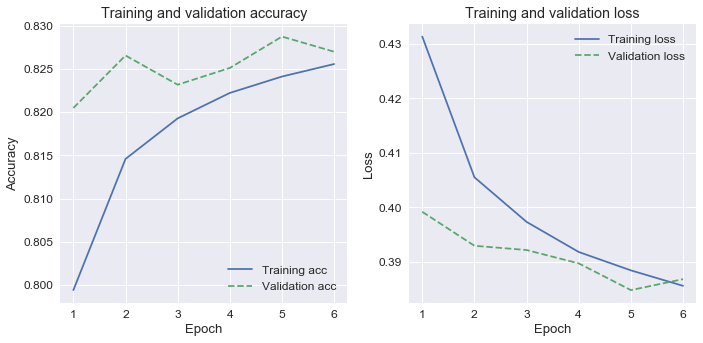

In [30]:
performance_plot (history_8_w2v)


### CNN + LSTM (fine-tune pre-trained word2vec)


In [20]:


# Model 9: CNN + LSTM


def model_9 (max_features=100000, embed_dim=200, dropout = 0.2, nb_filter = 128,conv_window = 3, 
             pool_size=2, output_dense_dim = 256, embedding_matrix = embedding_matrix, 
             recurrent_dropout = 0.2, embeddings_regularizer = regularizers.l2(1e-6),
             LSTM_out = 128):
    
    model = Sequential()

    model.add(Embedding(max_features, embed_dim, weights =[embedding_matrix],
                        input_length = maxlen, trainable = True, 
                        embeddings_regularizer = embeddings_regularizer))

    model.add(Conv1D(nb_filter, conv_window, activation='relu'))
    
    model.add(MaxPooling1D(pool_size))
    
    model.add(Conv1D(nb_filter, conv_window, activation='relu'))
    
    model.add(LSTM(LSTM_out, dropout=dropout, recurrent_dropout=recurrent_dropout))
    
    model.add(Dense(output_dense_dim, activation='relu'))

    model.add(Dropout(dropout))

    model.add(Dense(1, activation='sigmoid'))
    
    print(model.summary())
    
    return model


In [21]:
# CNN + LSTM (fine-tune pre-trained word2vec)
model_9_w2v = model_9(dropout = 0.2, output_dense_dim = 256)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 60, 200)           20000000  
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 58, 128)           76928     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 29, 128)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 27, 128)           49280     
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
__________

In [ ]:
# compile the model
compile_model(model_9_w2v)

# fit on the training set
history_9_w2v = fit_model(model_9_w2v, callbacks_list('9_w2v'), batch_size=256)



Train on 1564120 samples, validate on 15960 samples
Epoch 1/6


In [ ]:
# Load the best model
best_model_9_w2v = load_model('model_9_w2v.h5')
Loss, Accuracy = best_model_9_w2v.evaluate(x=X_val_sequences, y=y_val)
print('CNN + LSTM (fine-tune pre-trained word2vec with L2 regularization)')
print('Accuracy: %f' % (Accuracy*100))



In [ ]:
performance_plot (history_9_w2v)


### CNN + LSTM (Fixed pre-trained word2vec)



In [28]:


# Model 9: CNN + LSTM


def model_9_f (max_features=100000, embed_dim=200, dropout = 0.2, nb_filter = 128,conv_window = 3, 
             pool_size=2, output_dense_dim = 256, embedding_matrix = embedding_matrix, 
             recurrent_dropout = 0.2,LSTM_out = 128):
    
    model = Sequential()

    model.add(Embedding(max_features, embed_dim, weights =[embedding_matrix],
                        input_length = maxlen, trainable = False)) 
                        

    model.add(Conv1D(nb_filter, conv_window, activation='relu'))
    
    model.add(MaxPooling1D(pool_size))
    
    model.add(Dropout(dropout))
    
    #model.add(Conv1D(nb_filter, conv_window, activation='relu'))
    
    model.add(LSTM(LSTM_out, dropout=dropout, recurrent_dropout=recurrent_dropout))
    
    model.add(Dense(output_dense_dim, activation='relu'))

    model.add(Dropout(dropout))

    model.add(Dense(1, activation='sigmoid'))
    
    print(model.summary())
    
    return model



In [29]:
# CNN + LSTM (Fixed pre-trained word2vec)
model_9_w2v_fixed = model_9_f(dropout = 0.2, output_dense_dim = 256)



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 60, 200)           20000000  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 58, 128)           76928     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 29, 128)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 29, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
___________________________

In [ ]:
# compile the model
compile_model(model_9_w2v_fixed)

# fit on the training set
history_9_w2v_fixed = fit_model(model_9_w2v_fixed, callbacks_list('9_w2v_fixed'), batch_size=256)



Instructions for updating:
Use tf.cast instead.
Train on 1564120 samples, validate on 15960 samples
Epoch 1/6


In [ ]:
# Load the best model
best_model_9_w2v_fixed = load_model('model_9_w2v_fixed.h5')
Loss, Accuracy = best_model_9_w2v_fixed.evaluate(x=X_val_sequences, y=y_val)
print('CNN + LSTM (Fixed pre-trained word2vec)')
print('Accuracy: %f' % (Accuracy*100))



In [ ]:
performance_plot (history_9_w2v_fixed)

In [ ]:
# anaconda faced some problems when running the code
# I had run it with pycharm and saved the result

#history_9_w2v_fixed_historyresult.csv
#model_9_w2v_fixed.h5

best_model_9_w2v_fixed = load_model('model_9_w2v_fixed.h5')
Loss, Accuracy = best_model_9_w2v_fixed.evaluate(x=X_val_sequences, y=y_val)
print('CNN + LSTM (Fixed pre-trained word2vec)')
print('Accuracy: %f' % (Accuracy*100))



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [11]:
history_9_w2v_fixed_historyresult = pd.read_csv('history_9_w2v_fixed_historyresult.csv', index_col=0)
history_9_w2v_fixed_historyresult


,val_loss,val_acc,loss,acc,lr
0,0.392502,0.821554,0.420118,0.805805,0.001
1,0.382622,0.828133,0.393138,0.821838,0.001
2,0.377188,0.831454,0.384587,0.826678,0.001
3,0.376298,0.832080,0.379758,0.829223,0.001
4,0.374860,0.832769,0.376089,0.831049,0.001
5,0.372113,0.832644,0.373623,0.832600,0.001


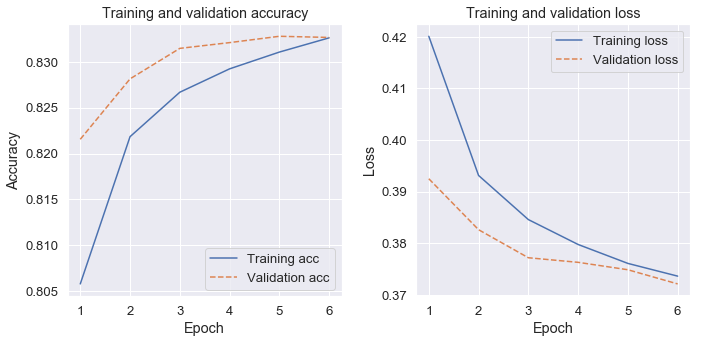

In [16]:
acc = history_9_w2v_fixed_historyresult['acc']
val_acc = history_9_w2v_fixed_historyresult['val_acc']
loss = history_9_w2v_fixed_historyresult['loss']
val_loss = history_9_w2v_fixed_historyresult['val_loss']
epochs = range(1, len(acc) + 1)
    
plt.figure(figsize=(10,5))
sns.set(font_scale=1.2)   
sns.set_style('darkgrid')

plt.subplot(1,2,1)   
plt.plot(epochs, acc, '-', label='Training acc')
plt.plot(epochs, val_acc, '--', label='Validation acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)


plt.subplot(1,2,2)
plt.plot(epochs, loss, '-', label='Training loss')
plt.plot(epochs, val_loss, '--', label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
    
plt.tight_layout()


### LSTM + CNN (fine-tune pre-trained word2vec)


In [ ]:
# Model 10: LSTM + CNN


def model_10 (max_features=100000, embed_dim=200, dropout=0.2, nb_filter=128, conv_window=3, LSTM_out=128
             pool_size=2, output_dense_dim = 256, embedding_matrix = embedding_matrix, 
             recurrent_dropout = 0.2, embeddings_regularizer = regularizers.l2(1e-6)):
    
    model = Sequential()

    model.add(Embedding(max_features, embed_dim, weights =[embedding_matrix],
                        input_length = maxlen, trainable = True, 
                        embeddings_regularizer = embeddings_regularizer))
    
    model.add(LSTM(LSTM_out, dropout=dropout, recurrent_dropout=recurrent_dropout))

    model.add(Conv1D(nb_filter, conv_window, activation='relu'))
    
    model.add(MaxPooling1D(pool_size))
    
    model.add(Conv1D(nb_filter, conv_window, activation='relu'))
    
    model.add(Dense(output_dense_dim, activation='relu'))

    model.add(Dropout(dropout))

    model.add(Dense(1, activation='sigmoid'))
    
    print(model.summary())
    
    return model



In [ ]:
# LSTM + CNN (fine-tune pre-trained word2vec)
model_10_w2v = model_10(dropout = 0.2, output_dense_dim = 256)




In [ ]:
# compile the model
compile_model(model_10_w2v)

# fit on the training set
history_10_w2v = fit_model(model_10_w2v, callbacks_list('10_w2v'), batch_size=256)


In [ ]:
# Load the best model
best_model_10_w2v = load_model('model_10_w2v.h5')
Loss, Accuracy = best_model_10_w2v.evaluate(x=X_val_sequences, y=y_val)
print('LSTM + CNN (fine-tune pre-trained word2vec with L2 regularization)')
print('Accuracy: %f' % (Accuracy*100))



In [ ]:
performance_plot (history_10_w2v)



### LSTM + CNN (Fixed pre-trained word2vec)

In [22]:
# Model 10: LSTM + CNN
from keras.layers import Reshape

def model_10_f (max_features=100000, embed_dim=200, dropout=0.2, nb_filter=128, conv_window=3, 
             pool_size=2, output_dense_dim = 256, embedding_matrix = embedding_matrix, 
             recurrent_dropout = 0.2, LSTM_out=128):
    
    model = Sequential()

    model.add(Embedding(max_features, embed_dim, weights =[embedding_matrix],
                        input_length = maxlen, trainable = False))
    
    model.add(LSTM(LSTM_out, dropout=dropout, recurrent_dropout=recurrent_dropout))
    
    model.add(Reshape((LSTM_out, 1)))

    model.add(Conv1D(nb_filter, conv_window, activation='relu'))
    
    model.add(MaxPooling1D(pool_size))
    
    model.add(Conv1D(nb_filter, conv_window, activation='relu'))
    
    model.add(Flatten())
    
    model.add(Dense(output_dense_dim, activation='relu'))

    model.add(Dropout(dropout))

    model.add(Dense(1, activation='sigmoid'))
    
    print(model.summary())
    
    return model




In [23]:
# LSTM + CNN (fine-tune pre-trained word2vec)
model_10_w2v_fixed = model_10_f(dropout = 0.2, output_dense_dim = 256)





_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 60, 200)           20000000  
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               168448    
_________________________________________________________________
reshape_2 (Reshape)          (None, 128, 1)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 126, 128)          512       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 63, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 61, 128)           49280     
_________________________________________________________________
flatten_1 (Flatten)          (None, 7808)              0         
__________

In [ ]:
# compile the model
compile_model(model_10_w2v_fixed)

# fit on the training set
history_10_w2v_fixed = fit_model(model_10_w2v_fixed, callbacks_list('10_w2v_fixed'), batch_size=256)



Instructions for updating:
Use tf.cast instead.
Train on 1564120 samples, validate on 15960 samples
Epoch 1/6


In [ ]:
# Load the best model
best_model_10_w2v_fixed = load_model('model_10_w2v_fixed.h5')
Loss, Accuracy = best_model_10_w2v_fixed.evaluate(x=X_val_sequences, y=y_val)
print('LSTM + CNN (Fixed pre-trained word2vec)')
print('Accuracy: %f' % (Accuracy*100))




In [ ]:
performance_plot (history_10_w2v)




# An Inception Module with CNN


An Inception Module consists of a stack of modules that themselves look like small independent networks, split into several parallel branches. Here, we want to adopt this idea and create different branches of conolutional neural nets with the help of keras functional API.
The proposed model has three branches containing convolutions with window sizes of 3, 4, and 5, and ending with the concatenation of the resulting features. This setup helps the network separately learn spatial features and channel-wise features, which is more efficient than learning them jointly.



In [25]:
from keras.layers import Input, concatenate
from keras.models import Model



def model_11(max_features=100000, embed_dim=200, dropout=0.2, output_dense_dim=256,
             embedding_matrix=embedding_matrix, nb_filter_a=128, conv_window_a=3,
             pool_size_a=2, nb_filter_b=128, conv_window_b=4,
             nb_filter_c=128, conv_window_c=5):

    tweets_input = Input(shape=(maxlen,), dtype='int32')

    embed_layer = Embedding(max_features, embed_dim, weights=[embedding_matrix],
                            input_length=maxlen, trainable=False)(tweets_input)

    branch_a = Conv1D(nb_filter_a, conv_window_a, activation='relu')(embed_layer)
    branch_a = GlobalMaxPooling1D()(branch_a)
    

    branch_b = Conv1D(nb_filter_b, conv_window_b, activation='relu')(embed_layer)
    branch_b = GlobalMaxPooling1D()(branch_b)
    

    branch_c = Conv1D(nb_filter_c, conv_window_c, activation='relu')(embed_layer)
    branch_c = GlobalMaxPooling1D()(branch_c)
    

    output = concatenate([branch_a, branch_b, branch_c], axis=1)
    output = Dropout(dropout)(output)
    output = Dense(output_dense_dim, activation='relu')(output)
    output = Dropout(dropout)(output)
    output = Dense(1, activation='sigmoid')(output)

    model = Model(inputs=[tweets_input], outputs=[output])

    print(model.summary())

    return model





In [26]:
# An Inception Module for CNN (fine_tune pre-trained word2vec)
model_11_w2v = model_11(dropout = 0.2, output_dense_dim = 256)




__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 60)           0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 60, 200)      20000000    input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 58, 128)      76928       embedding_4[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 57, 128)      102528      embedding_4[0][0]                
__________________________________________________________________________________________________
conv1d_3 (

In [ ]:
# compile the model
compile_model(model_11_w2v)

# fit on the training set
history_11_w2v = fit_model(model_11_w2v, callbacks_list('11_w2v'), batch_size=256)



In [ ]:
# Load the best model
best_model_11_w2v = load_model('model_11_w2v.h5')
Loss, Accuracy = best_model_11_w2v.evaluate(x=X_val_sequences, y=y_val)
print('An Inception Module for CNN (fine-tune pre-trained word2vec with L2 regularization)')
print('Accuracy: %f' % (Accuracy*100))



In [ ]:
performance_plot (history_11_w2v)



# An Inception Module with LSTM


In [27]:

def model_12 (max_features = 100000, embed_dim = 200, dropout = 0.2, output_dense_dim = 128, 
              embedding_matrix = embedding_matrix, embeddings_regularizer = regularizers.l2(1e-6),
              LSTM_out=64 ,dropout_a=0.2 ,dropout_b=0.2 ,dropout_c=0.2 ,
              recurrent_dropout_a=0.2 ,recurrent_dropout_b=0.2 ,recurrent_dropout_c=0.2):
              

    tweets_input = Input(shape=(maxlen,), dtype='int32')

    embed_layer = Embedding(max_features, embed_dim, weights =[embedding_matrix],
                            input_length = maxlen, trainable = True, 
                            embeddings_regularizer = embeddings_regularizer)(tweets_input)

    branch_a = LSTM(LSTM_out, dropout=dropout_a, recurrent_dropout=recurrent_dropout_a)(embed_layer)
    
    branch_b = LSTM(LSTM_out, dropout=dropout_b, recurrent_dropout=recurrent_dropout_b)(embed_layer)
    
    branch_c = LSTM(LSTM_out, dropout=dropout_c, recurrent_dropout=recurrent_dropout_c)(embed_layer)

    
    output = concatenate([branch_a, branch_b, branch_c], axis=1)
    output = Dense(output_dense_dim, activation='relu')(output)
    output = Dropout(dropout)(output)
    output = Dense(1, activation='sigmoid')(output)
    
    model = Model(inputs=[tweets_input], outputs=[output])
    
    print(model.summary())
    
    return model



In [31]:
# An Inception Module for LSTM (fine_tune pre-trained word2vec)
model_12_w2v = model_12(dropout = 0.2, output_dense_dim = 128)



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 60)           0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 60, 200)      20000000    input_5[0][0]                    
__________________________________________________________________________________________________
lstm_9 (LSTM)                   (None, 64)           67840       embedding_7[0][0]                
__________________________________________________________________________________________________
lstm_10 (LSTM)                  (None, 64)           67840       embedding_7[0][0]                
__________________________________________________________________________________________________
lstm_11 (L

In [ ]:
# compile the model
compile_model(model_12_w2v)

# fit on the training set
history_12_w2v = fit_model(model_12_w2v, callbacks_list('12_w2v'), batch_size=256)



In [ ]:
# Load the best model
best_model_12_w2v = load_model('model_12_w2v.h5')
Loss, Accuracy = best_model_12_w2v.evaluate(x=X_val_sequences, y=y_val)
print('An Inception Module for LSTM (fine-tune pre-trained word2vec with L2 regularization)')
print('Accuracy: %f' % (Accuracy*100))



In [ ]:
performance_plot (history_12_w2v)


### An Inception Module with LSTM, CNN, Bidirectional LSTM

In [34]:

def model_13 (max_features = 100000, embed_dim = 200, dropout = 0.2, output_dense_dim = 128, 
              embedding_matrix = embedding_matrix, embeddings_regularizer = regularizers.l2(1e-6),
              LSTM_out_a=128, recurrent_dropout_a=0.2 ,dropout_a=0.2 ,nb_filter_b=128, conv_window_b=3 ,
              LSTM_out_c=128,dropout_c=0.2 ,recurrent_dropout_c=0.2):
              

    tweets_input = Input(shape=(maxlen,), dtype='int32')

    embed_layer = Embedding(max_features, embed_dim, weights =[embedding_matrix],
                            input_length = maxlen, trainable = True, 
                            embeddings_regularizer = embeddings_regularizer)(tweets_input)

    branch_a = LSTM(LSTM_out_a, dropout=dropout_a, recurrent_dropout=recurrent_dropout_a)(embed_layer)
    
    branch_b = Conv1D(nb_filter_b, conv_window_b, activation='relu')(embed_layer)
    branch_b = GlobalMaxPooling1D()(branch_b)
    
    branch_c = Bidirectional(LSTM(LSTM_out_c, 
                                  dropout=dropout_c, 
                                  recurrent_dropout=recurrent_dropout_c,
                                  return_sequences=True))(embed_layer) 
    branch_c = Flatten()(branch_c)
    branch_c = Dense(output_dense_dim, activation='relu')(branch_c)

    
    output = concatenate([branch_a, branch_b, branch_c], axis=1)
    output = Dense(output_dense_dim, activation='relu')(output)
    output = Dropout(dropout)(output)
    output = Dense(1, activation='sigmoid')(output)
    
    model = Model(inputs=[tweets_input], outputs=[output])
    
    print(model.summary())
    
    return model




In [35]:
# An Inception Module with LSTM, CNN, Bidirectional LSTM (fine_tune pre-trained word2vec)
model_13_w2v = model_13(output_dense_dim = 128)



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 60)           0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 60, 200)      20000000    input_7[0][0]                    
__________________________________________________________________________________________________
bidirectional_6 (Bidirectional) (None, 60, 256)      336896      embedding_9[0][0]                
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 58, 128)      76928       embedding_9[0][0]                
__________________________________________________________________________________________________
flatten_5 

In [ ]:
# compile the model
compile_model(model_13_w2v)

# fit on the training set
history_13_w2v = fit_model(model_13_w2v, callbacks_list('13_w2v'), batch_size=256)




In [ ]:
# Load the best model
best_model_13_w2v = load_model('model_13_w2v.h5')
Loss, Accuracy = best_model_13_w2v.evaluate(x=X_val_sequences, y=y_val)
print('An Inception Module with LSTM, CNN, Bidirectional LSTM (fine-tune pre-trained word2vec)')
print('Accuracy: %f' % (Accuracy*100))




In [ ]:
performance_plot (history_13_w2v)
